In [472]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import date
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [473]:
conn = sqlite3.connect('data/noshow.db')
df = pd.read_sql_query('SELECT * FROM noshow', conn)

Lets start by just getting the shape of our dataset so we know what we are working with.

In [474]:
df.shape

(119391, 15)

We have 119390 data points and 15 features in this dataset. Now lets take a look at 

In [475]:
df

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,4823,0.0,Changi,September,April,3.0,April,5.0,China,Yes,King,USD$ 612.18,Website,1,1.0
119387,25062,0.0,Orchard,March,December,30.0,January,3.0,China,Yes,King,USD$ 1041.29,Email,2,0.0
119388,81936,1.0,Changi,September,March,31.0,April,1.0,Indonesia,Yes,King,USD$ 641.47,Email,1,2.0
119389,6738,0.0,Changi,February,February,25.0,February,27.0,China,Yes,None,SGD$ 886.35,Website,2,0.0


Now that we have a overview of our dataframe, lets start the doing a basic cleaning before we begin our exploration. 

We will start by checking if there are any null values

In [476]:
df.isna().sum()

booking_id            0
no_show               1
branch                1
booking_month         1
arrival_month         1
arrival_day           1
checkout_month        1
checkout_day          1
country               1
first_time            1
room              21613
price             24882
platform              1
num_adults            1
num_children          1
dtype: int64

There seems to be one missing from almost all the columns (apart from room and price which have way more). I suspect this might be the same data point. Checking. 

In [477]:
df[df['no_show'].isna()]

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
111598,115536,NaN,None,None,None,NaN,None,NaN,None,None,None,None,None,None,NaN


As suspected, this is just a datapoint with full null values. For ease of analysis, will just remove it now. 

In [478]:
df.dropna(subset=['no_show'], inplace=True)
df[df['no_show'].isna()]

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children


In [479]:
df.isna().sum()

booking_id            0
no_show               0
branch                0
booking_month         0
arrival_month         0
arrival_day           0
checkout_month        0
checkout_day          0
country               0
first_time            0
room              21612
price             24881
platform              0
num_adults            0
num_children          0
dtype: int64

Yep so the na values for all of the features apart from room and price have been removed. Now lets take a closer look at room and price. 

In [480]:
df[df['room'].isna()]

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
5,55212,0.0,Orchard,November,September,12.0,September,13.0,Indonesia,Yes,None,SGD$ 1499.61,Website,2,2.0
8,109456,1.0,Changi,January,June,27.0,June,28.0,China,Yes,None,USD$ 658.75,Email,2,1.0
9,31117,0.0,Orchard,October,March,22.0,March,24.0,China,Yes,None,USD$ 962.75,Website,1,1.0
17,85014,0.0,Orchard,March,May,10.0,May,12.0,Indonesia,Yes,None,SGD$ 1309.13,Website,one,0.0
19,3158,0.0,Orchard,March,March,30.0,March,31.0,China,Yes,None,USD$ 1056.7,Website,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119357,7903,0.0,Orchard,August,October,12.0,October,13.0,Indonesia,Yes,None,USD$ 534.97,Email,1,1.0
119358,108888,0.0,Orchard,December,February,10.0,February,12.0,China,Yes,None,SGD$ 1200.95,Website,2,0.0
119370,53658,1.0,Changi,April,October,4.0,October,6.0,China,Yes,None,SGD$ 844.46,Agent,one,0.0
119378,91840,0.0,Orchard,September,September,15.0,September,-16.0,Australia,Yes,None,SGD$ 1331.2,Agent,2,0.0


It's missing a lot of data points. We will probably have to end up filling up the data as 21612 data points are missing values. Lets take a look at the missing values for price.

In [481]:
df[df['price'].isna()]

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
7,23137,0.0,Changi,July,November,18.0,November,19.0,India,Yes,King,None,Email,2,1.0
15,99392,0.0,Orchard,December,August,13.0,August,15.0,India,Yes,Queen,None,Phone,1,1.0
16,28623,0.0,Changi,December,February,22.0,February,23.0,Indonesia,Yes,King,None,Website,2,2.0
18,28009,0.0,Changi,June,July,30.0,July,31.0,Japan,Yes,King,None,Agent,two,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119364,25132,0.0,Changi,April,September,4.0,September,5.0,Malaysia,Yes,King,None,Agent,1,2.0
119367,41443,0.0,Changi,May,September,3.0,September,4.0,Japan,Yes,King,None,Website,1,2.0
119374,116904,0.0,Changi,January,February,15.0,February,-16.0,India,Yes,Single,None,Website,1,1.0
119382,8794,0.0,Orchard,April,February,7.0,February,9.0,China,No,King,None,Website,1,2.0


I'm currently hoping that we aren't missing any values from both room and price in the same row. Lets take a look. As that would make it easier to fill in missing values. As based on my experience room type would be a good predictor of price. 

In [482]:
df[(df['price'].isna())&(df['room'].isna())]

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children


There are no datapoints where both price and room are null. Therefore, current thought is to use a combination of branch, booking_month and price to fill in missing values for **room** and a combination of branch, booking_month and room to fill in missing values for **price**. We will now proceed with our data exploration and see if these are the best features to choose to approximate the missing values. 

Now we shall take a look at the numerical valued features and see if there are any datapoints that do not make sense.

In [483]:
df.describe()

,booking_id,no_show,arrival_day,checkout_day,num_children
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,59694.532281,0.370416,15.798241,14.250507,0.871229
std,34465.122764,0.482918,8.780829,11.063697,0.779796
min,0.000000,0.000000,1.000000,-31.000000,0.000000
25%,29847.250000,0.000000,8.000000,7.000000,0.000000
50%,59694.500000,0.000000,16.000000,15.000000,1.000000
75%,89541.750000,1.000000,23.000000,23.000000,1.000000
max,119390.000000,1.000000,31.000000,31.000000,3.000000


It is interesting that **num_children** feature is shown when calling describe() function but **num_adults** and **price** is not. Which means its been treated as a categorical feature rather than numerical. Just to make sure that there are no issues, we will take a closer look at **num_adults** and **price**. We will then take a look at the values for the 3 features above to ensure that they are all whole numbers (i.e no decimals). Also, for ease of reading, we will sort the values. 

In [484]:
df['num_adults'].unique()

array(['1', '2', 'one', 'two'], dtype=object)

It seems that the data has been entered in multiple ways. As we want to be consistent(to allow for proper analysis) and this is an ordinal feature, we will just simply change everything to numeric (we will have to eventually do this anyway before inputting it into the model). So one -> 1, two -> 2 and as the numbers currently in the column are string type, we will convert that to int as well (so '1' -> 1 and '2' -> 2). 

In [485]:
df['num_adults'].replace('one', 1, inplace=True)
df['num_adults'].replace('two', 2, inplace=True)
df['num_adults'].replace('1', 1, inplace=True)
df['num_adults'].replace('2', 2, inplace=True)
df['num_adults'].unique()

array([1, 2])

We will now take a closer look at the **price** feature

In [486]:
df['price'].unique()

array(['SGD$ 492.98', 'SGD$ 1351.22', None, ..., 'USD$ 612.18',
       'USD$ 1041.29', 'SGD$ 886.35'], dtype=object)

It seems that there are several currencies used when recording price. Unsure how many so will have to check. 

In [487]:
df_currency = df['price'].str[:4]
df_currency.unique()

array(['SGD$', None, 'USD$'], dtype=object)

We can see that there are 2 currencies being used to record price. We want this to be all consistent. Based on the **branch** feature (having 2 branches Changi and Orchard), the hotel chain's data was collected from Singapore. So we will use SGD as the currency and remove the 'SGD$' prefix. We will convert 'USD$' to 'SGD$' using the current exchange rate which is: 1.39 SGD$ = 1 USD$ (taken 15 June 8.45pm SG Time). It would also be interesting to see if there is a relationship between payment currency and the other features. So we will be extracting that out and creating a new feature column called **payment_currency**. 

In [488]:
def convertCurrencyStringToInt64(price):
    '''
    Takes a price(string) in either USD$ or SGD$ and returns the price in SGD$ without the SGD$ prefix. If no currency in input returns input
    '''
    str(price).replace(" ", "") #remove white spaces
    if str(price)[:4] == "USD$":
        return np.round(float(str(price)[4:]) *1.39, 2) #multiply if price is in USD; keeping it to 2 decimals as its a price
    if str(price)[:4] == "SGD$":
        return np.round(float(str(price)[4:]), 2) #price is in SGD; keeping to 2 decimals as its a price
    return price

def extractCurrency(price):
    '''
    Takes a price (string) in either USD$ or SGD$ and returns the currency that payment was made in. If neither of the two currency in input returns input
    '''
    if str(price)[:4] == "USD$":
        return "USD"
    if str(price)[:4] == "SGD$":
        return "SGD"
    return price

In [489]:
df['payment_currency'] = df['price'].apply(extractCurrency)
df['price'] = df['price'].apply(convertCurrencyStringToInt64)
df['payment_currency'].unique()

array(['SGD', None, 'USD'], dtype=object)

Now we will take a look at the other 4 features (**booking_id**, **arrival_day**, **num_children** and **checkout_day**) to ensure there are no decimal values. They should all be whole numbers. We will be sorting the unique values to allow for better visualization (so we are more easily able to see if certain numbers are missing)

First looking at **booking_id**, my first thought is that since the booking_id is unique to the customer, we can take a look and see if there are repeat customers. 

In [490]:
df['booking_id'].nunique() == df.shape[0]

True

Unfortunately there seems to be no repeat customers. Since this **booking_id** is assigned by the hotel to the customer we can assume that the **booking_id** is in chronological order. So it might be interesting to try and see if we can glean any patterns if we sort the dataframe by booking_id. 

In [491]:
np.sort(df['arrival_day'].unique())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31.])

In [492]:
np.sort(df['num_children'].unique())

array([0., 1., 2., 3.])

In [493]:
np.sort(df['checkout_day'].unique())

array([-31., -30., -29., -28., -27., -26., -25., -24., -23., -22., -21.,
       -20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   1.,   2.,
         3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.])

It seems that the **checkout_day** feature has both negative and positive values of all the possible days in a month [1,31]. Taking a look at the negatives to see if they signify anything in particular. 

In [494]:
df[df['checkout_day'] < 0]

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children,payment_currency
43,76711,1.0,Orchard,July,October,3.0,October,-4.0,China,Yes,King,1417.02,Email,2,1.0,SGD
69,59927,1.0,Orchard,August,September,7.0,September,-10.0,India,Yes,King,1341.59,Phone,1,2.0,USD
99,53781,0.0,Changi,July,January,1.0,January,-3.0,Indonesia,Yes,None,556.22,Phone,1,0.0,SGD
117,104943,1.0,Changi,September,October,5.0,October,-6.0,China,Yes,King,940.97,Website,1,2.0,SGD
160,11871,1.0,Changi,January,June,3.0,June,-5.0,China,Yes,King,820.23,Agent,1,1.0,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119271,98681,0.0,Changi,December,August,2.0,August,-7.0,Singapore,Yes,King,1012.13,Email,1,0.0,USD
119346,109300,1.0,Changi,July,March,15.0,March,-18.0,China,Yes,King,812.90,Agent,1,0.0,USD
119371,96230,0.0,Changi,August,May,26.0,May,-27.0,Indonesia,Yes,Single,449.36,Website,1,1.0,USD
119374,116904,0.0,Changi,January,February,15.0,February,-16.0,India,Yes,Single,NaN,Website,1,1.0,None


Nothing immediately jumps out as a reason for the negative (might just be a mistake), but just to be sure, I would like to check if perhaps only certain branches input this wrongly as I am only seeing **Changi** and **Orchard** branches here. 

In [495]:
df['branch'].unique()

array(['Changi', 'Orchard'], dtype=object)

So there are only 2 branches in the dataset. So therefore, there appears to be no particular reason for the negative values. I will assume that if **checkout_day** entry is negative, it is simply a data entry error where a '-' was added by accident. So will change all entries to its absolute value. So all positive values will remain unchanged but negative values will be mapped to their positive. For example,    |-31| -> 31. 

In [496]:
df['checkout_day'] = df['checkout_day'].abs()
df[df['checkout_day']<0]

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children,payment_currency


Now lets take a look at the nominal features to ensure there is no issues with the data.

In [497]:
df['branch'].unique()

array(['Changi', 'Orchard'], dtype=object)

In [498]:
df['booking_month'].unique()

array(['November', 'August', 'March', 'September', 'July', 'January',
       'October', 'June', 'December', 'April', 'May', 'February'],
      dtype=object)

In [499]:
df['room'].unique()

array(['Single', 'King', 'Queen', None, 'President Suite'], dtype=object)

In [500]:
df['arrival_month'].unique()

array(['June', 'November', 'February', 'October', 'September', 'March',
       'May', 'August', 'July', 'January', 'April', 'December', 'ApRiL',
       'OcTobeR', 'JuNe', 'JulY', 'ApriL', 'OctOber', 'DecembEr',
       'SeptEmber', 'JanUary', 'JUne', 'FeBruary', 'JanuarY', 'DEcember',
       'SePtember', 'DecembeR', 'MaY', 'NoVember', 'JUly', 'JunE', 'JuLy',
       'FebrUary', 'NOvember', 'SeptemBer', 'OctobeR', 'DecemBer',
       'MarCh', 'AuguSt', 'AugusT', 'APril', 'SepTember', 'NovembEr',
       'FEbruary', 'DeceMber', 'AuGust', 'SepteMber', 'FebruaRy',
       'OctoBer', 'JanuaRy', 'MarcH', 'ApRil', 'AUgust', 'JanuAry',
       'NOveMber', 'MaRch', 'AprIl', 'MAy', 'NovemBer', 'DecEmber',
       'MArch', 'JaNuary', 'NovembeR', 'SeptembEr', 'FebruarY',
       'SeptembeR', 'OcTober', 'DeCember', 'FebruAry', 'AugUst',
       'NovEmber', 'NoveMber', 'OctobEr', 'OCtober', 'SEptember',
       'JAnuary', 'SeptEMber', 'MAY', 'FebRuary', 'FeBruarY', 'OCTober',
       'JUnE', 'DecEMber', 'Febru

The arrival month feature seems to have had loads of punctuation errors when being keyed in. It has capital letters in various places within the string leading to the same month being considered as different entries. Will change them all so that they are consistent. 

In [501]:
def stringConvert(month: str):
    '''
    this function takes a string and returns the string with just the first letter capitalized. String must have minimum length = 1
    '''
    month = month.lower()
    return month[0].upper() + month[1:]

df['arrival_month'] = df['arrival_month'].apply(stringConvert)
df['arrival_month'].unique()

array(['June', 'November', 'February', 'October', 'September', 'March',
       'May', 'August', 'July', 'January', 'April', 'December'],
      dtype=object)

In [502]:
df['checkout_month'].unique()

array(['June', 'November', 'February', 'October', 'September', 'March',
       'May', 'August', 'July', 'January', 'April', 'December'],
      dtype=object)

In [503]:

df['country'].unique()

array(['Singapore', 'Indonesia', 'India', 'China', 'Australia', 'Japan',
       'Malaysia'], dtype=object)

In [504]:
df['first_time'].unique()

array(['Yes', 'No'], dtype=object)

In [505]:
df['platform'].unique()

array(['Website', 'Agent', 'Email', 'Phone'], dtype=object)

Now we will check to make sure that there are no incorrect entries between months and days. For example, the month of April should not have a checkout_day of 31. We can ignore all months with 31 days as we have already checked that the largest data entered is 31 days. I checked through all the months and there was only one detail that stood out. 

In [506]:
df[(df['arrival_month'] == "February")&(df['arrival_day']>28)].head()

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children,payment_currency
6314,4663,1.0,Changi,May,February,29.0,March,2.0,China,Yes,King,971.87,Website,1,1.0,USD
9141,80461,1.0,Changi,May,February,29.0,March,2.0,China,Yes,King,NaN,Website,2,0.0,None
11658,93563,0.0,Changi,May,February,29.0,March,2.0,Indonesia,Yes,King,935.86,Website,2,2.0,SGD
13660,24163,1.0,Changi,May,February,29.0,March,2.0,China,Yes,King,NaN,Website,2,1.0,None
16386,95194,1.0,Changi,December,February,29.0,March,2.0,Indonesia,Yes,King,929.88,Website,2,2.0,SGD


This tells us that some of the years where the data was collected were leap years! (as we don't know over how long this data was collected so cannot assume its all in the same year)

All the nominal features seem to have no issues now. I will now add in 2 additional columns that I think will be interesting to do analysis on/with. They are:  
&emsp; 1. The number of months between booking and check in. I will be assuming that if a room is booked in an earlier month than arrival_month it was made in the same year and if a room is booked in a later month than arrival_month, the booking was made the previous year. If booking_month and arrival_month are the same, will be assuming that the booking was made in the same month as arrival (i.e not the previous year). Will be creating a new feature called **booked_months_before** for this.  
&emsp; 2. The number of days the customer booked to stay at the hotel. Will be assuming that no customer stays more than a year. Will be creating a new feature called **days_booked** for this. 

In [507]:
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
def bookedMonthsBefore(booked_month: str, checkIn_month: str):
    '''
    this function will return the number of months between 2 given months inclusive of earlier month. Assumed that the difference is less than 1 year 
    and that the first variable is the earlier month and the second variable is later month.
    '''
    x = month_list.index(booked_month)
    y = month_list.index(checkIn_month)
    if y >= x:
        return y - x
    else:
        return 12 -(x - y)
df['booked_months_before'] = df.apply(lambda x: bookedMonthsBefore(x['booking_month'], x['arrival_month']), axis=1)
df[['booking_month', 'arrival_month', 'booked_months_before']]

,booking_month,arrival_month,booked_months_before
0,November,June,7
1,August,November,3
2,March,February,11
3,September,October,1
4,March,June,3
...,...,...,...
119386,September,April,7
119387,March,December,9
119388,September,March,6
119389,February,February,0


We do not know enough about the dataset to know the sequeuence that the data was entered. So we will assume that all data points are in non-leap years apart from the data points where there is February 29th inputted as the arrival_day. 

In [508]:
def daysBooked(arrival_day: float, arrival_month: str, checkout_day: float, checkout_month: str):
    '''
    this function takes in 4 inputs a earlier date and month (1st and second input) and a later date and month (3rd and 4th input). It will calculate the number of days between the 2 date and month pairs. 
    It assumes that there is no leap year unless a leap year date (29 feb) is given in the earlier date and month
    '''
    leap_year = False
    x = month_list.index(arrival_month)
    y = month_list.index(checkout_month)
    if (arrival_month == 'February') and (arrival_day == float(29)): #only check for (arrival_month and arrival_day) as we know (checkout_day and checkout_month) does not have any leap year entries from above
        leap_year = True
    if leap_year == True:
        if y >=x:
            delta = date(2020, month_list.index(checkout_month) + 1, int(checkout_day)) - date(2020, month_list.index(arrival_month) + 1, int(arrival_day)) #2020 was a leap year
            return delta.days
        else: 
            delta = date(2020, month_list.index(checkout_month) + 1, int(checkout_day)) - date(2019, month_list.index(arrival_month) + 1, int(arrival_day))
            return delta.days
    else:
        if y >=x:
            delta = date(2022, month_list.index(checkout_month) + 1, int(checkout_day)) - date(2022, month_list.index(arrival_month) + 1, int(arrival_day))
            return delta.days
        else: 
            delta = date(2022, month_list.index(checkout_month) + 1, int(checkout_day)) - date(2021, month_list.index(arrival_month) + 1, int(arrival_day))
            return delta.days
df['days_booked'] = df.apply(lambda x: daysBooked(x['arrival_day'], x['arrival_month'], x['checkout_day'], x['checkout_month']), axis=1)
df[['arrival_day', 'arrival_month', 'checkout_day', 'checkout_month', 'days_booked']]

,arrival_day,arrival_month,checkout_day,checkout_month,days_booked
0,25.0,June,27.0,June,2
1,28.0,November,29.0,November,1
2,7.0,February,11.0,February,4
3,1.0,October,3.0,October,2
4,20.0,June,24.0,June,4
...,...,...,...,...,...
119386,3.0,April,5.0,April,2
119387,30.0,December,3.0,January,4
119388,31.0,March,1.0,April,1
119389,25.0,February,27.0,February,2


Now that we have finished with feature engineering and the basic data cleaning we can move on to the fun stuff. The exploration!

### Data Exploration

We will break this down into 3 sections:  
&emsp; 1. Univariate Analysis (where we try and get an understanding of each individual feature, the distribution of its datapoints and see if we can identify any relationship it might have with the target)  
&emsp; 2. Bivariate Analysis (where we take a look at pairs of features and try )

### Univariate Analysis

Here we will examine each feature individually. We will take a look at the attributes of each feature and take note of anything interesting. We will then see if there is any relationship we can glean between the feature and the target we are trying to predict. 

In [509]:
df_no_show = df.loc[df['no_show'] == 1.0] #seperating to make doing univariate analysis easier
df_show = df.loc[df['no_show'] == 0.0]
df.columns

Index(['booking_id', 'no_show', 'branch', 'booking_month', 'arrival_month',
       'arrival_day', 'checkout_month', 'checkout_day', 'country',
       'first_time', 'room', 'price', 'platform', 'num_adults', 'num_children',
       'payment_currency', 'booked_months_before', 'days_booked'],
      dtype='object')

##### booking_id

In [510]:
df['booking_id'].describe()

count    119390.000000
mean      59694.532281
std       34465.122764
min           0.000000
25%       29847.250000
50%       59694.500000
75%       89541.750000
max      119390.000000
Name: booking_id, dtype: float64

In [511]:
df['booking_id'].nunique()

119390

So it looks like the booking_id's go from 0 to 119390. As there are 119390 datapoints and there are 119390 unique values within booking_id this tells us that there were no repeat customers within this dataset (as we are told that the booking_id is unique to the customer and no repeats means no repeat customers). I think there's nothing much to glean from this feature by itself. However, if we assume that booking_id is given to a booking in chronological order we might be able to see some interesting clusterings if we take a look at the relationship between booking_id and no_show columns. Perhaps during certain periods, a lot more no_shows occured?

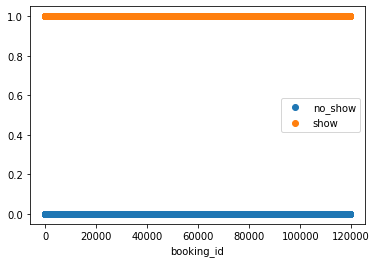

In [512]:
plt.plot(df_no_show['booking_id'], np.zeros_like(df_no_show['booking_id']), 'o')
plt.plot(df_show['booking_id'], np.ones_like(df_show['booking_id']), 'o')
plt.xlabel('booking_id')
plt.gca().legend(('no_show', 'show'))
plt.show()

Doesn't really seem to be much of a indication of anything here. I think unless something else shows up we will be excluding this feature during model building. 

##### branch

We know from data cleaning that there are 2 branches (Changi and Orchard). Lets take a look at a bar plot of the 2 just to see how many of each there are. 

([<matplotlib.patches.Wedge at 0x7fc6c94c4f50>,
 [Text(-0.5433858480011854, 0.956416133381298, 'changi'),
  Text(0.5433858480011848, -0.9564161333812984, 'orchard')],
 [Text(-0.29639228072791923, 0.5216815272988897, '66.4%'),
  Text(0.29639228072791896, -0.52168152729889, '33.6%')])

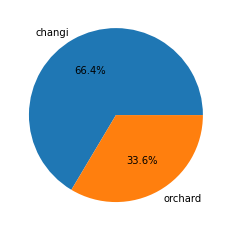

In [513]:
plt.pie(df['branch'].value_counts(), autopct='%1.1f%%', labels=['changi', 'orchard'])

So 66.4% of customers stayed at the Changi branch and 33.6% of customers stayed at Orchard. Lets take a look if there exists any obvious relationships between the branch and no_show feature. 

([<matplotlib.patches.Wedge at 0x7fc6c9411b50>,
 [Text(-0.7741621628670241, 0.7814556581054688, 'changi'),
  Text(0.7741622360321797, -0.7814555856231726, 'orchard')],
 [Text(-0.4222702706547404, 0.4262485407848011, '74.9%'),
  Text(0.42227031056300707, -0.4262485012490032, '25.1%')])

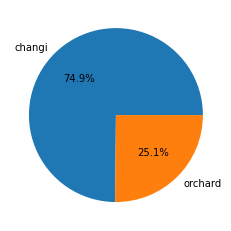

In [514]:
plt.pie(df_no_show['branch'].value_counts(), autopct='%1.1f%%', labels=['changi', 'orchard'])

([<matplotlib.patches.Wedge at 0x7fc6c9365850>,
 [Text(-0.38886147309004243, 1.0289736414244257, 'changi'),
  Text(0.38886147309004276, -1.0289736414244255, 'orchard')],
 [Text(-0.21210625804911404, 0.5612583498678685, '61.5%'),
  Text(0.2121062580491142, -0.5612583498678684, '38.5%')])

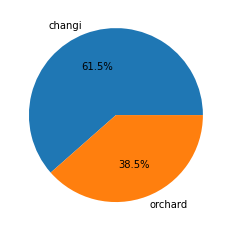

In [515]:
plt.pie(df_show['branch'].value_counts(), autopct='%1.1f%%', labels=['changi', 'orchard'])

Of the customers that were no_show, 74.9% of them booked the Changi branch and of the customers that showed up, 61.5% were booked into the Changi branch. Now lets take a look at the distribution of show against no_show within each branch.

([<matplotlib.patches.Wedge at 0x7fc6c92b1890>,
 [Text(-0.28268769122520404, 1.0630558166106632, 'show'),
  Text(0.28268769122520365, -1.0630558166106634, 'no_show')],
 [Text(-0.15419328612283853, 0.5798486272421799, '58.3%'),
  Text(0.15419328612283834, -0.5798486272421799, '41.7%')])

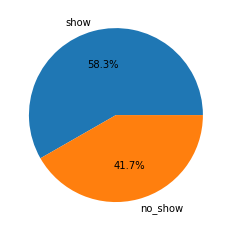

In [516]:
df_changi = df[df['branch'] == 'Changi']
plt.pie(df_changi['no_show'].value_counts(), autopct='%1.1f%%', labels=['show', 'no_show'])

([<matplotlib.patches.Wedge at 0x7fc6c9204750>,
 [Text(-0.7074481122900579, 0.8423284207583369, 'show'),
  Text(0.7074481122900578, -0.842328420758337, 'no_show')],
 [Text(-0.38588078852184976, 0.4594518658681837, '72.2%'),
  Text(0.38588078852184965, -0.45945186586818376, '27.8%')])

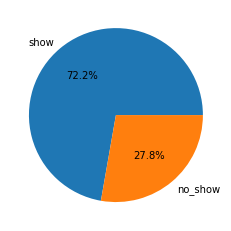

In [517]:
df_orchard = df[df['branch'] == 'Orchard']
plt.pie(df_orchard['no_show'].value_counts(), autopct='%1.1f%%', labels=['show', 'no_show'])

Now this is interesting. If a customer were to book into the orchard branch, they had a 72.2% chance of turning up compared to the only 58.3% of customers who booked into the changi branch. This makes me think that branch might be a useful feature for predicting no_show. 

##### booking_month

We know there are no NaN fields in this feature, so a pie chart would be ideal again to get distribution of months. 

([<matplotlib.patches.Wedge at 0x7fc6c9153850>,
 [Text(1.0596586927175888, 0.29516682562247876, 'January'),
  Text(0.7546544442874452, 0.8003103583718052, 'February'),
  Text(0.2337305226956133, 1.0748814086960643, 'March'),
  Text(-0.35140477976256534, 1.0423601492574546, 'April'),
  Text(-0.8340498032844673, 0.7171896022957539, 'May'),
  Text(-1.0824993145910797, 0.19543600975726827, 'June'),
  Text(-1.033588146054253, -0.37642468614071045, 'July'),
  Text(-0.710251733119657, -0.8399657585881247, 'August'),
  Text(-0.21093945045535328, -1.0795853594049865, 'September'),
  Text(0.3372749591807473, -1.0470174792760747, 'October'),
  Text(0.8010844308456839, -0.7538326967282906, 'November'),
  Text(1.0653709131384554, -0.27383355791161484, 'December')],
 [Text(0.5779956505732302, 0.16100008670317023, '8.6%'),
  Text(0.411629696884061, 0.43653292274825733, '8.6%'),
  Text(0.12748937601578905, 0.5862989501978532, '8.6%'),
  Text(-0.1916753344159447, 0.568560081413157, '8.6%'),
  Text(-0.4

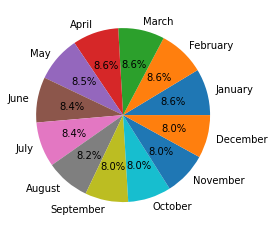

In [518]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['booking_month'].value_counts()[months]
plt.pie(df['booking_month'].value_counts(), autopct='%1.1f%%', labels=months)

There seems to be a roughly even distribution of customers across all booking months. Lets see within each booking month what the distribution of show against no_show is.

Text(0.5, 1.0, 'Dec')

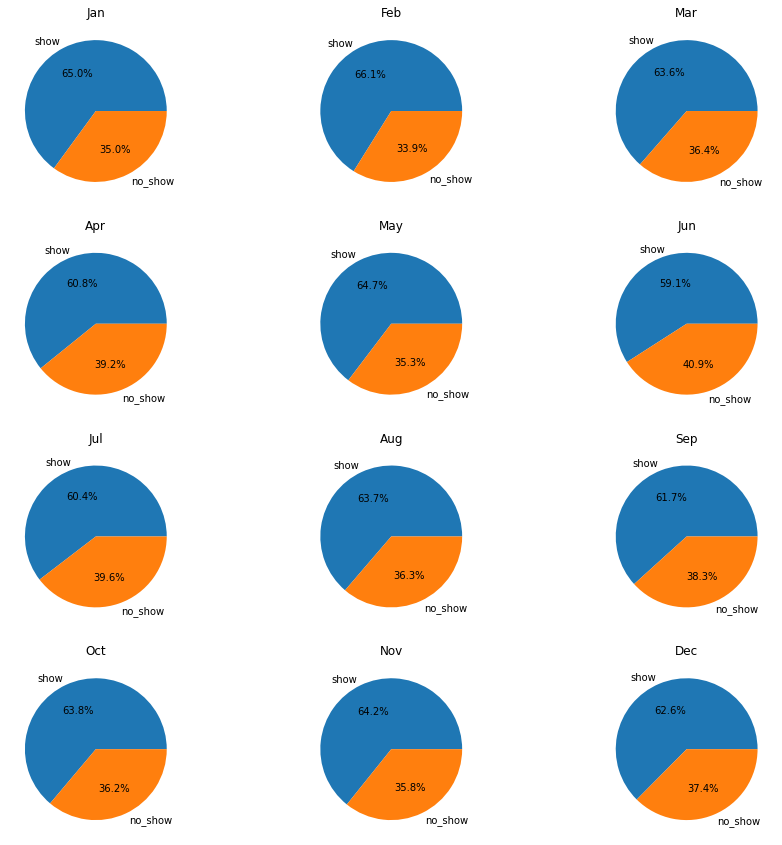

In [519]:
labels = [0.0, 1.0]
labels2 = ['show', 'no_show']
fig = plt.figure(figsize = (15,15))
fig.add_subplot(4,3,1)
pie_jan = plt.pie(df[df['booking_month'] == 'January']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Jan')
fig.add_subplot(4,3,2)
pie_jan = plt.pie(df[df['booking_month'] == 'February']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Feb')
fig.add_subplot(4,3,3)
pie_jan = plt.pie(df[df['booking_month'] == 'March']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Mar')
fig.add_subplot(4,3,4)
pie_jan = plt.pie(df[df['booking_month'] == 'April']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Apr')
fig.add_subplot(4,3,5)
pie_jan = plt.pie(df[df['booking_month'] == 'May']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('May')
fig.add_subplot(4,3,6)
pie_jan = plt.pie(df[df['booking_month'] == 'June']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Jun')
fig.add_subplot(4,3,7)
pie_jan = plt.pie(df[df['booking_month'] == 'July']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Jul')
fig.add_subplot(4,3,8)
pie_jan = plt.pie(df[df['booking_month'] == 'August']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Aug')
fig.add_subplot(4,3,9)
pie_jan = plt.pie(df[df['booking_month'] == 'September']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Sep')
fig.add_subplot(4,3,10)
pie_jan = plt.pie(df[df['booking_month'] == 'October']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Oct')
fig.add_subplot(4,3,11)
pie_jan = plt.pie(df[df['booking_month'] == 'November']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Nov')
fig.add_subplot(4,3,12)
pie_jan = plt.pie(df[df['booking_month'] == 'December']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Dec')

The distribution of the show against no_show of customers seems relatively consistent across booking months with the highest no_show percentage being found in June but not by much. 

##### arrival_month

We know there are no NaN fields in this feature, so a pie chart would be ideal again to get distribution of months. 

([<matplotlib.patches.Wedge at 0x7fc6c90b6ed0>,
 [Text(1.0274751813027496, 0.3928037064576685, 'January'),
  Text(0.5344280274802672, 0.9614503021183939, 'February'),
  Text(-0.1492421940111399, 1.0898287789954628, 'March'),
  Text(-0.7417330924629526, 0.8123004490613956, 'April'),
  Text(-1.0670649138163826, 0.2671562645756907, 'May'),
  Text(-1.0390986370272917, -0.36093492838463936, 'June'),
  Text(-0.6849202836454534, -0.8607463070214311, 'July'),
  Text(-0.1512207275579927, -1.089556006617756, 'August'),
  Text(0.3586372867812689, -1.0398938871491505, 'September'),
  Text(0.727948781935322, -0.8246760399568314, 'October'),
  Text(0.9703409793804926, -0.5181103972464813, 'November'),
  Text(1.0866399378175706, -0.1709199974836944, 'December')],
 [Text(0.5604410079833179, 0.21425656715872823, '11.6%'),
  Text(0.29150619680741846, 0.5244274375191239, '10.6%'),
  Text(-0.08140483309698539, 0.5944520612702524, '9.9%'),
  Text(-0.40458168679797407, 0.44307297221530667, '9.3%'),
  Text(-

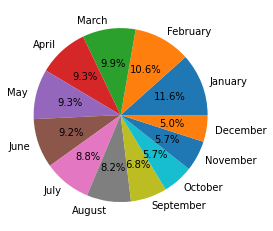

In [520]:
df['arrival_month'].value_counts()[months]
plt.pie(df['arrival_month'].value_counts(), autopct='%1.1f%%', labels=months)

It seems that the majority of customers booked hotel rooms from January (11.6%) while the smallest number of rooms were booked in December (5%). This is interesting as I would have thought that the majority of people would go on holiday in December but seems to not be the case here. Now lets take a look at the distribution of no_show against show within each month. 

Text(0.5, 1.0, 'Dec')

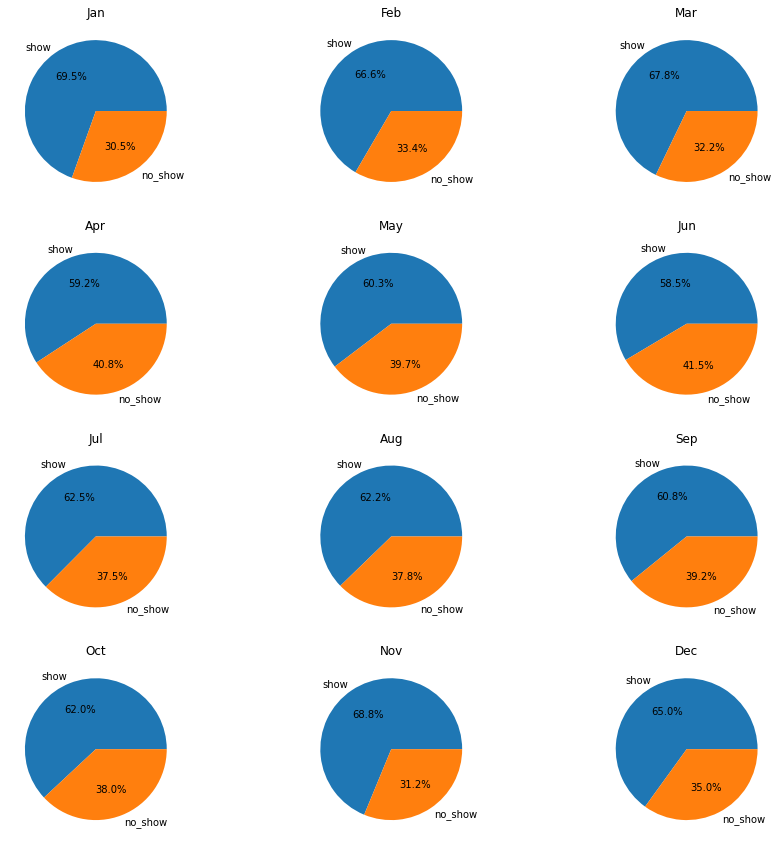

In [521]:
labels = [0.0, 1.0]
labels2 = ['show', 'no_show']
fig = plt.figure(figsize = (15,15))
fig.add_subplot(4,3,1)
pie_jan = plt.pie(df[df['arrival_month'] == 'January']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Jan')
fig.add_subplot(4,3,2)
pie_jan = plt.pie(df[df['arrival_month'] == 'February']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Feb')
fig.add_subplot(4,3,3)
pie_jan = plt.pie(df[df['arrival_month'] == 'March']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Mar')
fig.add_subplot(4,3,4)
pie_jan = plt.pie(df[df['arrival_month'] == 'April']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Apr')
fig.add_subplot(4,3,5)
pie_jan = plt.pie(df[df['arrival_month'] == 'May']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('May')
fig.add_subplot(4,3,6)
pie_jan = plt.pie(df[df['arrival_month'] == 'June']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Jun')
fig.add_subplot(4,3,7)
pie_jan = plt.pie(df[df['arrival_month'] == 'July']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Jul')
fig.add_subplot(4,3,8)
pie_jan = plt.pie(df[df['arrival_month'] == 'August']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Aug')
fig.add_subplot(4,3,9)
pie_jan = plt.pie(df[df['arrival_month'] == 'September']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Sep')
fig.add_subplot(4,3,10)
pie_jan = plt.pie(df[df['arrival_month'] == 'October']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Oct')
fig.add_subplot(4,3,11)
pie_jan = plt.pie(df[df['arrival_month'] == 'November']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Nov')
fig.add_subplot(4,3,12)
pie_jan = plt.pie(df[df['arrival_month'] == 'December']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Dec')

Again nothing too mcuh stands out. Although it is interesting to note that January which is the month with the most bookings is also the month with the lowest percentage of no_shows. While June and April had the largest percentage of no_shows at around 41%.

##### arrival_day -- skipping first in interest of time

##### checkout_month

([<matplotlib.patches.Wedge at 0x7fc6c82dd0d0>,
 [Text(1.0278983639075667, 0.39169497504582307, 'January'),
  Text(0.5339978930393193, 0.9616892690622934, 'February'),
  Text(-0.15981693218682136, 1.0883283273839715, 'March'),
  Text(-0.7606768143065394, 0.7945884369763098, 'April'),
  Text(-1.0743310692662336, 0.23624722984465107, 'May'),
  Text(-1.0315023895398145, -0.38210315410063367, 'June'),
  Text(-0.6749545615861127, -0.8685829492881487, 'July'),
  Text(-0.1494716467074616, -1.0897973329158774, 'August'),
  Text(0.34283534004440436, -1.045209993071554, 'September'),
  Text(0.7168603216119039, -0.8343328348437917, 'October'),
  Text(0.9655004595099959, -0.5270757656029985, 'November'),
  Text(1.0852190228084142, -0.179721096521112, 'December')],
 [Text(0.5606718348586727, 0.2136518045704489, '11.6%'),
  Text(0.2912715780214469, 0.5245577831248872, '10.7%'),
  Text(-0.08717287210190254, 0.5936336331185298, '10.1%'),
  Text(-0.4149146259853851, 0.4334118747143507, '9.6%'),
  Text(

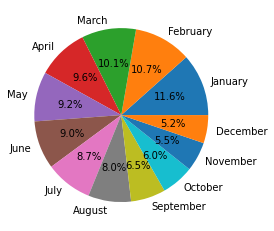

In [522]:
df['checkout_month'].value_counts()[months]
plt.pie(df['checkout_month'].value_counts(), autopct='%1.1f%%', labels=months)

The majority of customers checked out in January while the least number of customers checked out in December (6%). Considering the number of days_booked is on average 2 days (covered in days_booked analysis below), and the fact that the majority of arrival_months are January, January having the highest number of checkout's makes a lot of sense. Lets check the distirbution of show against no_show within each month although i suspect it will look similar to the arrival_month's piecharts as the majority of people would arrive and checkout within the same month. 

Text(0.5, 1.0, 'Dec')

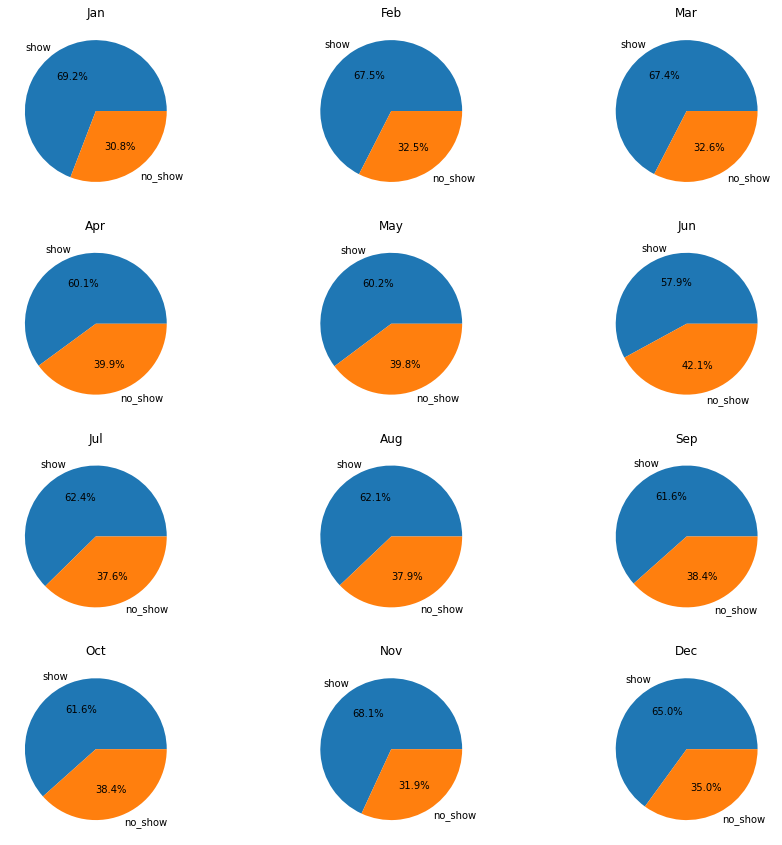

In [523]:
labels = [0.0, 1.0]
labels2 = ['show', 'no_show']
fig = plt.figure(figsize = (15,15))
fig.add_subplot(4,3,1)
pie_jan = plt.pie(df[df['checkout_month'] == 'January']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Jan')
fig.add_subplot(4,3,2)
pie_jan = plt.pie(df[df['checkout_month'] == 'February']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Feb')
fig.add_subplot(4,3,3)
pie_jan = plt.pie(df[df['checkout_month'] == 'March']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Mar')
fig.add_subplot(4,3,4)
pie_jan = plt.pie(df[df['checkout_month'] == 'April']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Apr')
fig.add_subplot(4,3,5)
pie_jan = plt.pie(df[df['checkout_month'] == 'May']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('May')
fig.add_subplot(4,3,6)
pie_jan = plt.pie(df[df['checkout_month'] == 'June']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Jun')
fig.add_subplot(4,3,7)
pie_jan = plt.pie(df[df['checkout_month'] == 'July']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Jul')
fig.add_subplot(4,3,8)
pie_jan = plt.pie(df[df['checkout_month'] == 'August']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Aug')
fig.add_subplot(4,3,9)
pie_jan = plt.pie(df[df['checkout_month'] == 'September']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Sep')
fig.add_subplot(4,3,10)
pie_jan = plt.pie(df[df['checkout_month'] == 'October']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Oct')
fig.add_subplot(4,3,11)
pie_jan = plt.pie(df[df['checkout_month'] == 'November']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Nov')
fig.add_subplot(4,3,12)
pie_jan = plt.pie(df[df['checkout_month'] == 'December']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Dec')

Comparing the 2 sets of graphs (distribution of target feature across arrival_month vs distributino of target feature across checkout_month) they are very similar. The percentages vary only slightly. I suspect these 2 features might be highly correlated with regards to predicting the target feature. It is important to note this for model building. 

##### country

([<matplotlib.patches.Wedge at 0x7fc6c7a37110>,
 [Text(1.0941770822959076, 0.11303323660948168, 'Singapore'),
  Text(0.6965438710330927, 0.8513675092028322, 'Indonesia'),
  Text(-0.437454963716521, 1.0092735777378588, 'India'),
  Text(-0.9478210511060347, -0.5582430071933298, 'China'),
  Text(0.5835765637787964, -0.9324368044045304, 'Australia'),
  Text(0.9927264541115679, -0.4738081756439765, 'Japan'),
  Text(1.0946032599885736, -0.10882877938480921, 'Malaysia')],
 [Text(0.596823863070495, 0.06165449269608091, '3.3%'),
  Text(0.37993302056350503, 0.46438227774699936, '21.6%'),
  Text(-0.2386117983908296, 0.5505128605842865, '13.2%'),
  Text(-0.5169933006032915, -0.3044961857418162, '40.7%'),
  Text(0.31831448933388895, -0.508601893311562, '10.2%'),
  Text(0.5414871567881279, -0.2584408230785326, '7.9%'),
  Text(0.597056323630131, -0.059361152391714106, '3.2%')])

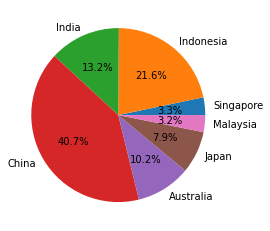

In [524]:
countries = df['country'].unique()
df['country'].value_counts()[countries]
plt.pie(df['country'].value_counts()[countries], autopct='%1.1f%%', labels=countries)

The majority of the hotels customers come from China (40.7%) and the smallest number of customers come from Singapore and Malaysia. This would make sense, as typically Singapore citizens would not stay at hotels in Singapore. Now lets take a look at the distribution of show against no_show within each country. 

Text(0.5, 1.0, 'India')

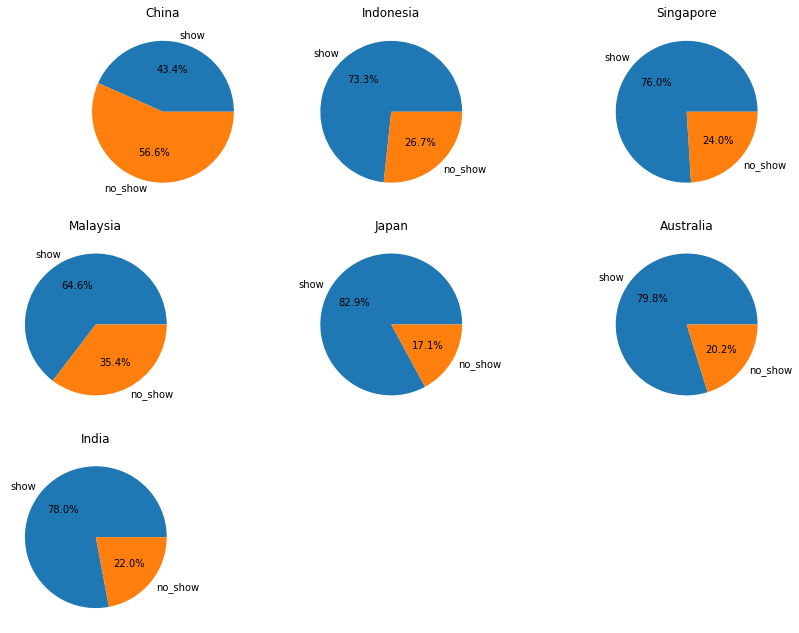

In [525]:
labels = [0.0, 1.0]
labels2 = ['show', 'no_show']
fig = plt.figure(figsize = (15,15))
fig.add_subplot(4,2,1)
plt.pie(df[df['country'] == 'China']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('China')
fig.add_subplot(4,3,2)
plt.pie(df[df['country'] == 'Indonesia']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Indonesia')
fig.add_subplot(4,3,3)
plt.pie(df[df['country'] == 'Singapore']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Singapore')
fig.add_subplot(4,3,4)
plt.pie(df[df['country'] == 'Malaysia']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Malaysia')
fig.add_subplot(4,3,5)
plt.pie(df[df['country'] == 'Japan']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Japan')
fig.add_subplot(4,3,6)
plt.pie(df[df['country'] == 'Australia']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Australia')
fig.add_subplot(4,3,7)
plt.pie(df[df['country'] == 'India']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('India')

The majority of the customers from China, did not show up (56.6%). This is very useful information as knowing that a customer is from China, is a good predictor of whether customer showed up. Interestingly, Japan had the lowest no_show rate at 17.1%. I would have thought it would be Singapore as if the customer is living locally, it is just a drive to the hotel rather than a flight. If the customer is living abroad, they would be more likely to turn up than other Nationalities as Singapore is their home and they would have some roots here. Considering that the majority of the other countries have roughly similar rates of no_show, I am considering changing the categories to (China, Malaysia, Japan and others) as that might make the model less complicated ideally reducing overfitting. Lets take a look at what that would look like.

Text(0.5, 1.0, 'Malaysia')

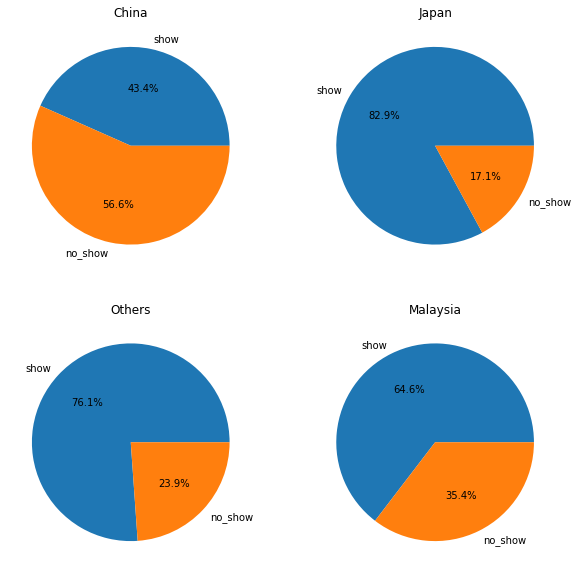

In [526]:
labels = [0.0, 1.0]
labels2 = ['show', 'no_show']
fig = plt.figure(figsize = (10,10))
fig.add_subplot(2,2,1)
plt.pie(df[df['country'] == 'China']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('China')
fig.add_subplot(2,2,2)
plt.pie(df[df['country'] == 'Japan']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Japan')
fig.add_subplot(2,2,3)
plt.pie(df[(df['country'] != 'China')&(df['country'] != 'Japan')&(df['country'] != 'Malaysia')]['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Others')
fig.add_subplot(2,2,4)
plt.pie(df[df['country'] == 'Malaysia']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Malaysia')

I think that 23.9% is not too far off from the percentages of countries within it (22%, 20.2%, 24%, 26.7%). It is something to consider when creating our model. This is because, for this nominal variables, we would have to do one hot encoding which will greatly increase the complexity of our model. So if we are able to reduce the number of unique variables within a nominal category we should consider it. 

##### first_time

([<matplotlib.patches.Wedge at 0x7fc6b9cae790>,
 [Text(-1.09447652566627, 0.11009602520295811, 'Yes'),
  Text(1.0944765295317447, -0.11009598677585064, 'No')],
 [Text(-0.5969871958179654, 0.060052377383431686, '96.8%'),
  Text(0.5969871979264061, -0.060052356423191254, '3.2%')])

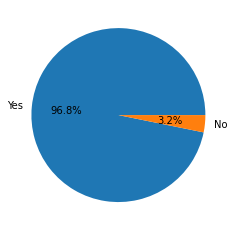

In [527]:
first_time = df['first_time'].unique()
df['first_time'].value_counts()[first_time]
plt.pie(df['first_time'].value_counts()[first_time], autopct='%1.1f%%', labels=first_time)

The overwhelming majority of customers who booked at this hotel, it was their first time. Not really super useful but perhaps we can glean something from looking at the distribution of no_show against show within the first_time feature. I would think that repeat customers would be much more likely to turn up. 

Text(0.5, 1.0, 'no')

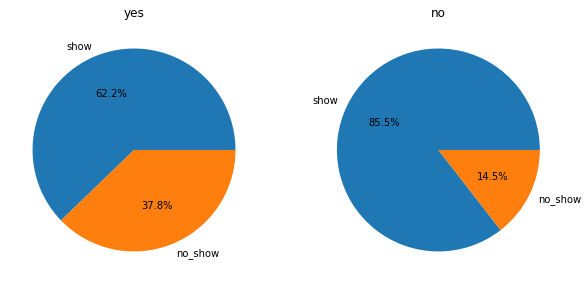

In [528]:
labels = [0.0, 1.0]
labels2 = ['show', 'no_show']
fig = plt.figure(figsize = (10,10))
fig.add_subplot(1,2,1)
plt.pie(df[df['first_time'] == 'Yes']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('yes')
fig.add_subplot(1,2,2)
plt.pie(df[df['first_time'] == 'No']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('no')

As predicted, only 14.5% of repeat customers were a no_show compared to the 37.8% of repeat customers. This seems like a useful feature for our model but we will still have to see as repeat customers only account for 3.2% of the overall dataset so it might not be worth including this feature in our model as it would add an additional layer of complexity without really being able to help classify the majority of our data. 

##### room

Lets take a look at the distribution of rooms

([<matplotlib.patches.Wedge at 0x7fc6b9ac7850>,
 [Text(-0.7037729546414508, 0.8454014598492497, 'King'),
  Text(0.348116381239194, -1.0434629773561341, 'Single'),
  Text(1.0145857030255037, -0.4249892365886988, 'Queen'),
  Text(1.0996712019098283, -0.026893264773808084, 'President Suite')],
 [Text(-0.38387615707715494, 0.46112806900868164, '72.1%'),
  Text(0.1898816624941058, -0.5691616240124368, '16.1%'),
  Text(0.5534103834684564, -0.23181231086656295, '11.1%'),
  Text(0.5998206555871789, -0.014669053512986226, '0.8%')])

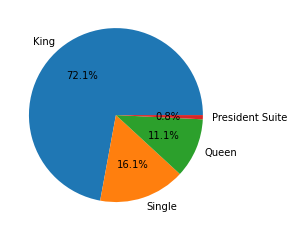

In [529]:
room = ['King', 'Single', 'Queen', 'President Suite'] 
plt.pie(df['room'].value_counts()[room], autopct='%1.1f%%', labels=room)

The overwhelming majority of customers booked King rooms (72.1%). While the smallest number of customers chose President Suite (0.8%). The number of customers for the President Suite would make sense as very few customers would be willing to pay for that level of luxury. However, the fact that the majority of customers chose King over Queen/Single is interesting.   
After a quick google, I found this:  
&emsp; 1. Single room - bed can fit 1 person comfortably   
&emsp; 2. Queen room - one queen size bed. Can fit 2 people comfortably and maybe 1 kid  
&emsp; 3. King room - one King size bed. Can fit 2 adults + 1/2 kids comfortably   
It might be worth considering that the number of people in the whole party so num_adults + num_kids might be indicative of the room booked by the party. We will investigate this in more detail later.   
Lets also take a look at the distribution of target feature within rooms feature

Text(0.5, 1.0, 'President Suite')

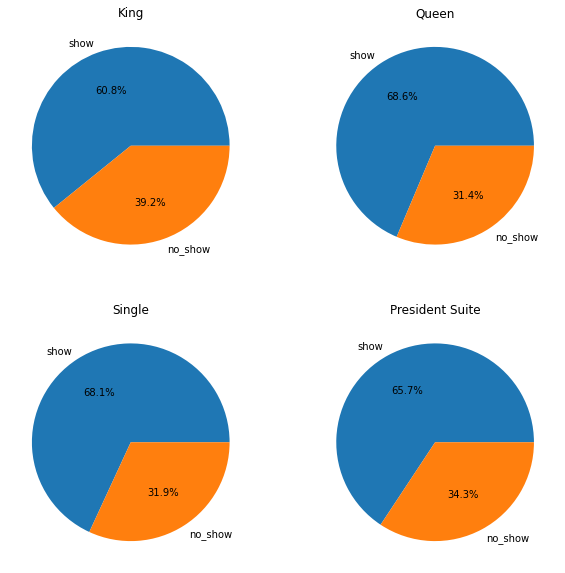

In [530]:
labels = [0.0, 1.0]
labels2 = ['show', 'no_show']
fig = plt.figure(figsize = (10,10))
fig.add_subplot(2,2,1)
plt.pie(df[df['room'] == 'King']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('King')
fig.add_subplot(2,2,2)
plt.pie(df[df['room'] == 'Queen']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Queen')
fig.add_subplot(2,2,3)
plt.pie(df[df['room'] == 'Single']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Single')
fig.add_subplot(2,2,4)
plt.pie(df[df['room'] == 'President Suite']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('President Suite')

Queen and Single rooms have very similar percentages of no_show vs show. President Suite has a higher percentage of 34.3% (~2% difference) but considering it only accounts for 0.8% of the data, it might be worth considering regrouping the rooms into (kings, others) that way reducing the number of nominal variables to reduce complexity of the model. Lets see what that would look like. 

Text(0.5, 1.0, 'Others')

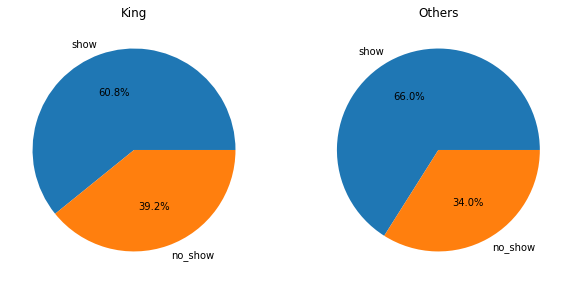

In [531]:
labels = [0.0, 1.0]
labels2 = ['show', 'no_show']
fig = plt.figure(figsize = (10,10))
fig.add_subplot(1,2,1)
plt.pie(df[df['room'] == 'King']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('King')
fig.add_subplot(1,2,2)
plt.pie(df[(df['room'] != 'King')&(df['room'] != 'None')]['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Others')

The overall no_show percentage of the others rooms is 34%. This is a bit far from the no_show percetages of Queen and Single but still worth considering due to the reduced complexity given to the model from this nominal data. 

##### platform

([<matplotlib.patches.Wedge at 0x7fc6af31e3d0>,
 [Text(0.1575255609277914, 1.0886623432701183, 'Website'),
  Text(-1.0557730361734634, -0.30877709774053347, 'Agent'),
  Text(0.15752566285571537, -1.088662328521506, 'Email'),
  Text(1.0557730795381504, -0.30877694946762246, 'Phone')],
 [Text(0.08592303323334076, 0.5938158236018827, '45.4%'),
  Text(-0.5758762015491617, -0.16842387149483642, '18.2%'),
  Text(0.0859230888303902, -0.5938158155571851, '27.3%'),
  Text(0.5758762252026274, -0.16842379061870316, '9.1%')])

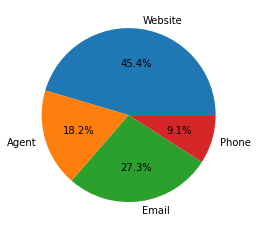

In [532]:
platform = df['platform'].unique()
plt.pie(df['platform'].value_counts()[platform], autopct='%1.1f%%', labels=platform)

The majority of the customers booked rooms using the website platform. This would make sense, as especially in recent times more and more people are becoming computer literate. So booking on the website, is easier and often times cheaper than using the other platforms. It is interesting that 27.3% (2nd highest) of customers book using Email. I did not even know you could do such a thing. Still interesting to note. Lets take a look at the distribution of no_show within the values of platform. 

Text(0.5, 1.0, 'Email')

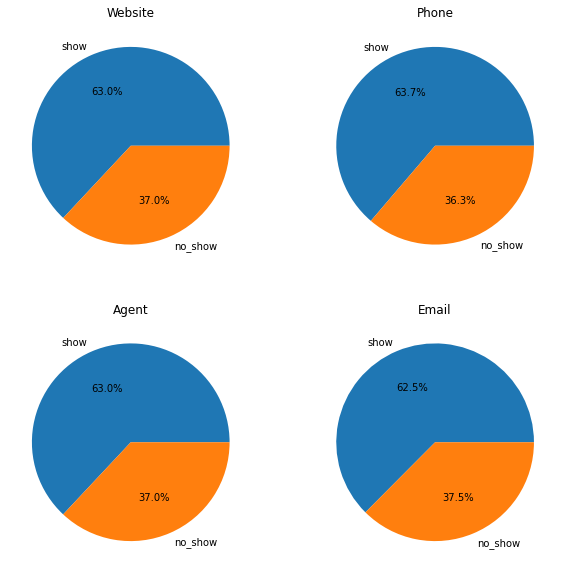

In [533]:
labels = [0.0, 1.0]
labels2 = ['show', 'no_show']
fig = plt.figure(figsize = (10,10))
fig.add_subplot(2,2,1)
plt.pie(df[df['platform'] == 'Website']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Website')
fig.add_subplot(2,2,2)
plt.pie(df[df['platform'] == 'Phone']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Phone')
fig.add_subplot(2,2,3)
plt.pie(df[df['platform'] == 'Agent']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Agent')
fig.add_subplot(2,2,4)
plt.pie(df[df['platform'] == 'Email']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Email')

There hardly seems to be any difference in terms of no_show against show percentages between all the platforms. As this is a nominal feature might be worth considering dropping it. As there doesn't seem to be much of a relationship between platform type and target. 

##### num_adults

([<matplotlib.patches.Wedge at 0x7fc6ad665e10>,
 [Text(-0.26886875511973946, 1.0666347043483826, '1'),
  Text(0.26886885498528623, -1.0666346791750685, '2')],
 [Text(-0.14665568461076697, 0.5818007478263905, '57.9%'),
  Text(0.14665573908288337, -0.5818007340954918, '42.1%')])

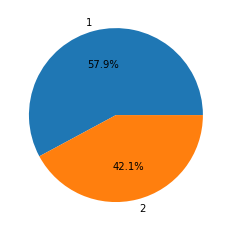

In [534]:
adults = df['num_adults'].unique()
plt.pie(df['num_adults'].value_counts()[adults], autopct='%1.1f%%', labels=adults)

The majority of the adult customers who came to the hotel came alone (1) rather than with another person. Now lets take a look a the distribution of our target variable over the num_adults feature

Text(0.5, 1.0, 'Two')

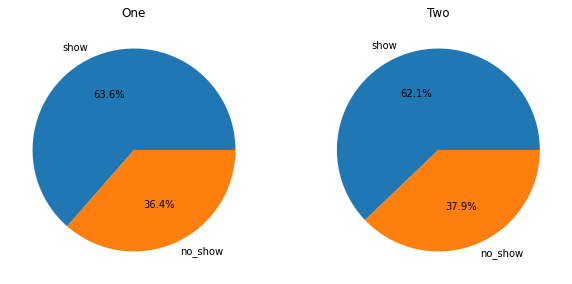

In [535]:
labels = [0.0, 1.0]
labels2 = ['show', 'no_show']
fig = plt.figure(figsize = (10,10))
fig.add_subplot(1,2,1)
plt.pie(df[df['num_adults'] == 1]['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('One')
fig.add_subplot(1,2,2)
plt.pie(df[df['num_adults'] == 2]['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('Two')

There does not seem to be much of a difference in no_show percentages between one adult and 2 adults. Might be worth considering combining the feature with num_children and seeing if there is something interesting there. 

##### num_children

([<matplotlib.patches.Wedge at 0x7fc6abf49590>,
 [Text(0.4221080489321543, 1.0157877706621055, '0.0'),
  Text(-1.0995591202105703, 0.031140667329981556, '2.0'),
  Text(0.38646976188675863, -1.0298743239576333, '1.0'),
  Text(1.0999765779441855, -0.007178298837435307, '3.0')],
 [Text(0.2302407539629932, 0.5540660567247847, '37.5%'),
  Text(-0.5997595201148566, 0.0169858185436263, '24.2%'),
  Text(0.21080168830186832, -0.5617496312496181, '38.2%'),
  Text(0.599987224333192, -0.003915435729510167, '0.2%')])

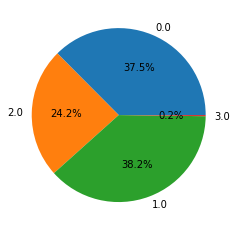

In [536]:
children = df['num_children'].unique()
plt.pie(df['num_children'].value_counts()[children], autopct='%1.1f%%', labels=children)

Seems that the majority of customers who booked had 1 child. With a close second being 2 children. With almost none of the customers having 3 children. Lets take a look at how the target is distributed within the num_children feature. 

Text(0.5, 1.0, '3')

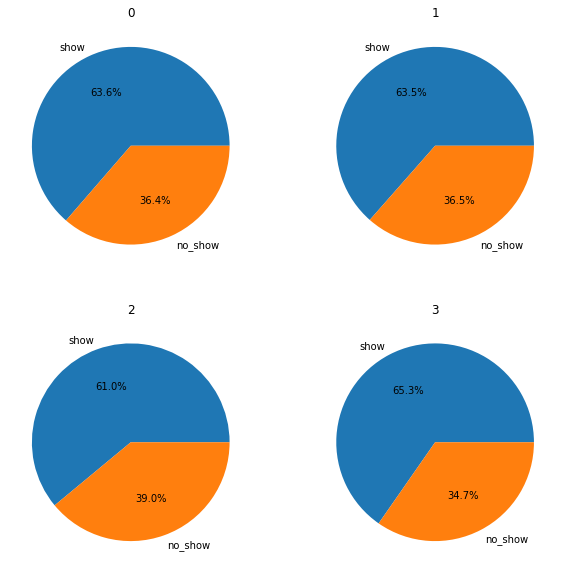

In [537]:
labels = [0.0, 1.0]
labels2 = ['show', 'no_show']
fig = plt.figure(figsize = (10,10))
fig.add_subplot(2,2,1)
plt.pie(df[df['num_children'] == 0.0]['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('0')
fig.add_subplot(2,2,2)
plt.pie(df[df['num_children'] == 1.0]['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('1')
fig.add_subplot(2,2,3)
plt.pie(df[df['num_children'] == 2.0]['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('2')
fig.add_subplot(2,2,4)
plt.pie(df[df['num_children'] == 3.0]['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('3')

The difference in no_show percentage between 0 and 1 kids is minimal. Might be worth considering combining the 2 into one category. Although considering this is ordinal might leave it. I would also like to create a new column called party_size which is just a sum of the num_adults and num_kids and see if that could be useful. 

##### party_size (new feature)

Lets start by creating the new column

In [538]:
def partySize(num_adults: int, num_children: float):
    '''
    this function will output the total of an int and a float as an int
    '''
    return num_adults + int(num_children)

df['party_size'] = df.apply(lambda x: partySize(x['num_adults'], x['num_children']), axis=1)
df[['num_adults', 'num_children', 'party_size']]

,num_adults,num_children,party_size
0,1,0.0,1
1,2,0.0,2
2,1,0.0,1
3,1,0.0,1
4,1,0.0,1
...,...,...,...
119386,1,1.0,2
119387,2,0.0,2
119388,1,2.0,3
119389,2,0.0,2


Lets take a look at the distribution within the feature

([<matplotlib.patches.Wedge at 0x7fc6abc03fd0>,
 [Text(0.8335022696039514, 0.7178258608918059, '1'),
  Text(-0.9503816542558744, 0.5538724684021293, '2'),
  Text(-0.5487126589931941, -0.9533700319711224, '4'),
  Text(0.7192504884400834, -0.8322732333066477, '3'),
  Text(1.0999924291129073, -0.004081163349589588, '5')],
 [Text(0.4546376016021552, 0.3915413786682577, '22.6%'),
  Text(-0.5183899932304769, 0.30211225549207055, '37.9%'),
  Text(-0.2992978139962877, -0.5200200174387939, '12.2%'),
  Text(0.39231844824004547, -0.4539672181672623, '27.1%'),
  Text(0.5999958704252221, -0.002226089099776139, '0.1%')])

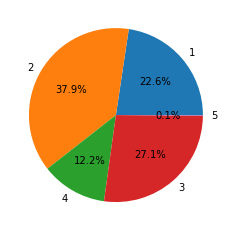

In [539]:
party = df['party_size'].unique()
plt.pie(df['party_size'].value_counts()[party], autopct='%1.1f%%', labels=party)

The majority party size is 2 at 37.9%. Worth noting that only 0.1% of all observations ahve a party size of 5. So might consider bringing it into 4.

Text(0.5, 1.0, '5')

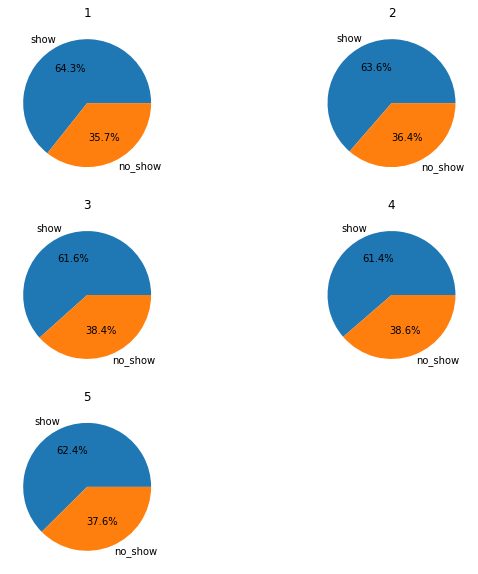

In [540]:
labels = [0.0, 1.0]
labels2 = ['show', 'no_show']
fig = plt.figure(figsize = (10,10))
fig.add_subplot(3,2,1)
plt.pie(df[df['party_size'] == 1]['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('1')
fig.add_subplot(3,2,2)
plt.pie(df[df['party_size'] == 2]['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('2')
fig.add_subplot(3,2,3)
plt.pie(df[df['party_size'] == 3]['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('3')
fig.add_subplot(3,2,4)
plt.pie(df[df['party_size'] == 4]['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('4')
fig.add_subplot(3,2,5)
plt.pie(df[df['party_size'] == 5]['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('5')

Similar to num_children and num_adults, there does not seem to be much difference with regards to relationship with target for party_size. However, if we were to proceed with this, I would merge the 4 and 5 categories into one called 4+ as there are so few 5 observations (0.1%). that it is probably not worth it to include it. I also note that 0.2% of the datapoints have num_children = 5 but here, only 0.1% of the observations have a party_size of 5. I suspect thats because the number of observations with 1 parent and 3 children is really small. Just to be sure, lets take a look.

In [541]:
df[(df['num_adults'] == 1)&(df['num_children'] == 3.0)].shape[0]

107

As suspected there are only 107 observations of this. So it doesn't come up on the pie chart because it accounts for less than 0.1% of the data. I wonder if the ratio of adults:kids is significant. Lets take a look at that. 

##### ratio_adults_kids (new feauture)

Lets first create our column. 

In [542]:
def ratioAdultsKids(num_adults: int, num_children: float):
    '''
    this function takes as input a int and a float and outputs a string of int:float
    '''
    return str(num_adults)+":"+str(int(num_children)) #int'ing the float first to remove the decimal to make it look cleaner

df['ratio_adults_kids'] = df.apply(lambda x: ratioAdultsKids(x['num_adults'], x['num_children']), axis=1)
df[['num_adults', 'num_children', 'ratio_adults_kids']]

,num_adults,num_children,ratio_adults_kids
0,1,0.0,1:0
1,2,0.0,2:0
2,1,0.0,1:0
3,1,0.0,1:0
4,1,0.0,1:0
...,...,...,...
119386,1,1.0,1:1
119387,2,0.0,2:0
119388,1,2.0,1:2
119389,2,0.0,2:0


Now lets take a look at the distribution. 

([<matplotlib.patches.Wedge at 0x7fc6898d3e90>,
 [Text(0.8335022696039514, 0.7178258608918059, '1:0'),
  Text(-0.34302787303300825, 1.045146821419101, '2:0'),
  Text(-1.0104669231005265, 0.43469138169482363, '2:2'),
  Text(-0.8405074939237382, -0.7096105640828899, '1:1'),
  Text(0.35551622714158515, -1.0409650389129372, '2:1'),
  Text(1.0169832068036586, -0.4192197002519646, '1:2'),
  Text(1.0999520060561028, -0.010275425692175624, '2:3'),
  Text(1.0999956397146238, -0.0030971937001101546, '1:3')],
 [Text(0.4546376016021552, 0.3915413786682577, '22.6%'),
  Text(-0.18710611256345902, 0.5700800844104187, '14.8%'),
  Text(-0.5511637762366507, 0.23710439001535832, '12.1%'),
  Text(-0.4584586330493117, -0.3870603076815763, '23.1%'),
  Text(0.19391794207722823, -0.5677991121343293, '15.0%'),
  Text(0.5547181128019956, -0.2286652910465261, '12.0%'),
  Text(0.5999738214851469, -0.005604777650277612, '0.1%'),
  Text(0.5999976216625219, -0.0016893783818782658, '0.1%')])

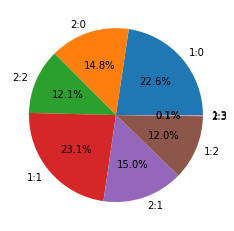

In [543]:
ratio = df['ratio_adults_kids'].unique()
plt.pie(df['ratio_adults_kids'].value_counts()[ratio], autopct='%1.1f%%', labels=ratio)

Interestingly, the largest ratio was 1:1 which is not what i would ahve guessed. As i would have thought that if parents were travelling with kids, both parents would be present. But that does not seem to be the case. Lets take a look at the distribution of the target within this feature. 

Text(0.5, 1.0, '2:3')

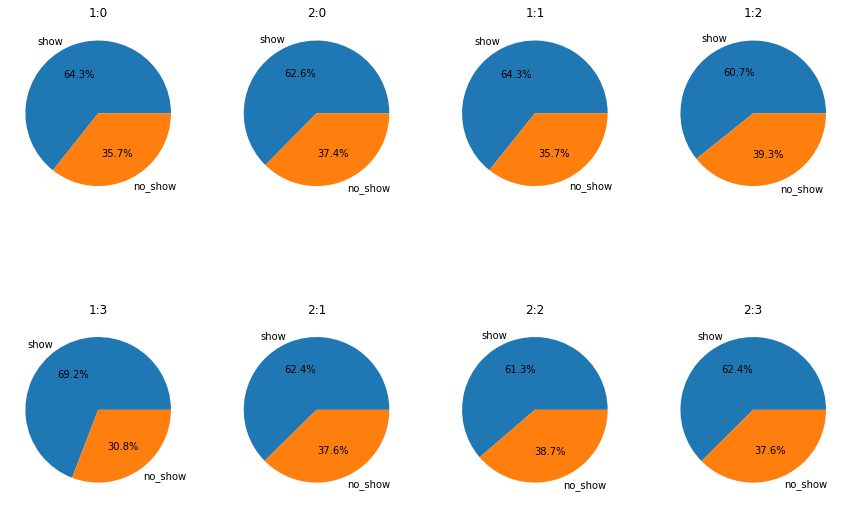

In [552]:
labels = [0.0, 1.0]
labels2 = ['show', 'no_show']
fig = plt.figure(figsize = (15,10))
fig.add_subplot(2,4,1)
plt.pie(df[df['ratio_adults_kids'] == '1:0']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('1:0')
fig.add_subplot(2,4,2)
plt.pie(df[df['ratio_adults_kids'] == '2:0']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('2:0')
fig.add_subplot(2,4,3)
plt.pie(df[df['ratio_adults_kids'] == '1:1']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('1:1')
fig.add_subplot(2,4,4)
plt.pie(df[df['ratio_adults_kids'] == '1:2']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('1:2')
fig.add_subplot(2,4,5)
plt.pie(df[df['ratio_adults_kids'] == '1:3']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('1:3')
fig.add_subplot(2,4,6)
plt.pie(df[df['ratio_adults_kids'] == '2:1']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('2:1')
fig.add_subplot(2,4,7)
plt.pie(df[df['ratio_adults_kids'] == '2:2']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('2:2')
fig.add_subplot(2,4,8)
plt.pie(df[df['ratio_adults_kids'] == '2:3']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('2:3')

Interestingly enough, the smallest number of observations (1:3) has the lowest no_show percentage (30.8%). Interestingly, 1:0 and 1:1 have almost the same percentages and 2:0 and 2:1 have almost the same percentages. If we end up using this feature, might merge them to reduce complexity. However, the ratio doesn't seem to be much of an indication for the target. 

##### payment_currency

([<matplotlib.patches.Wedge at 0x7fc68511dfd0>,
 [Text(-0.0014809875959596204, 1.099999003033976, 'SGD'),
  Text(0.0014810905852983634, -1.0999990028953108, 'USD')],
 [Text(-0.0008078114159779747, 0.5999994562003504, '50.0%'),
  Text(0.0008078675919809254, -0.599999456124715, '50.0%')])

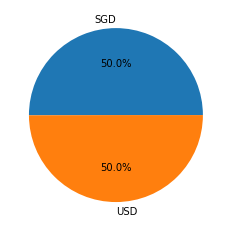

In [557]:
cur = ['SGD', 'USD']
plt.pie(df['payment_currency'].value_counts()[cur], autopct='%1.1f%%', labels=cur)

There seems to be a 50-50 split between payments being made in USD and in SGD. Lets see if there is any relationship between the target and the payment_currency feature value. 

Text(0.5, 1.0, 'USD')

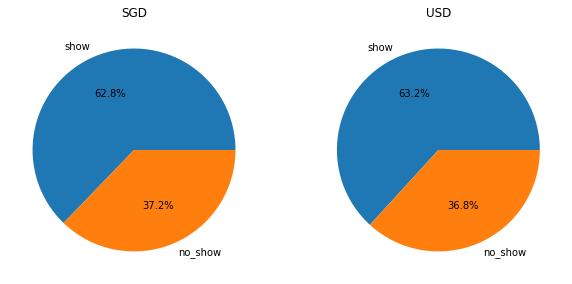

In [558]:
labels = [0.0, 1.0]
labels2 = ['show', 'no_show']
fig = plt.figure(figsize = (10,10))
fig.add_subplot(1,2,1)
plt.pie(df[df['payment_currency'] == 'SGD']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('SGD')
fig.add_subplot(1,2,2)
plt.pie(df[df['payment_currency'] == 'USD']['no_show'].value_counts()[labels], autopct='%1.1f%%', labels=labels2)
plt.title('USD')

There doesn't seem to be much of a difference here. Might not be worth including in the model. 

##### days_booked

In [54]:
df['days_booked'].describe()

count    119390.000000
mean          2.108677
std           2.168212
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max          64.000000
Name: days_booked, dtype: float64

Text(0.5, 1.0, 'days_booked')

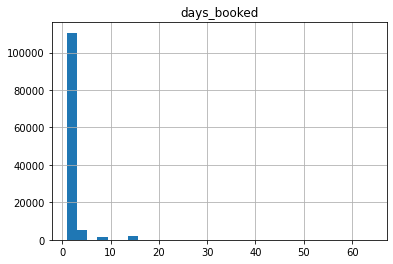

In [57]:
df['days_booked'].hist(bins = 30)
plt.title('days_booked')

We observe that almost all the number of days booked by the hotels customers are between 1 and 2. With very few customers staying for more than that. This is also supported by the describe() function above as the mean is very close to 2. 

<AxesSubplot:>

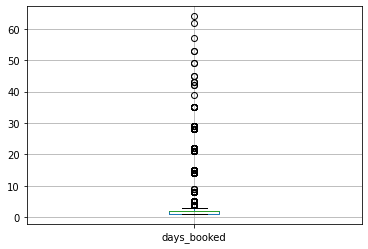

In [41]:
df.boxplot(column = 'days_booked')

From the histogram and the boxplot, it looks like this the **days_booked** feature does not follow a normal distribution. The boxplot has a large number of outliers. Which leads me to think that this feature might follow a pareto distirbution. Lets take a look at a normal plot of the days_booked and the count of the observation:

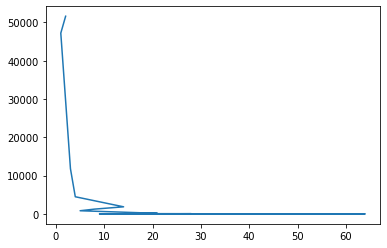

In [42]:
value_counts = df['days_booked'].value_counts(sort=True)
df_val_counts = pd.DataFrame(value_counts)
df_value_counts_reset = df_val_counts.reset_index()
df_value_counts_reset.columns = ['days_booked', 'count']
plt.plot(df_value_counts_reset['days_booked'], df_value_counts_reset['count'])

This does look like the pdf of a pareto distribution. This does make sense, as hotels are generally only stayed at for a few days. This is also a useful observation as we now know that if we were to use a model that assumes linearity of the features, we probably would not want to use this feature (for eg: logistic regression) without first normalizing it.

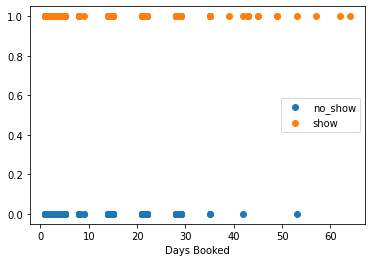

In [53]:
plt.plot(df_no_show['days_booked'], np.zeros_like(df_no_show['days_booked']), 'o')
plt.plot(df_show['days_booked'], np.ones_like(df_show['days_booked']), 'o')
plt.xlabel('Days Booked')
plt.gca().legend(('no_show', 'show'))
plt.show()

I also want to take a look at how long do customers stay based on room type. Do customers who book more expensive rooms stay longer? Lets see. 

In [43]:
pd.pivot_table(df, index= 'room', values = 'days_booked')

,days_booked
room,
King,1.976821
President Suite,2.303548
Queen,2.487251
Single,2.410715


It seems that on average most people who stay in King's on average tend to book between 1-2 days and the other room types between 2-3 days. I would also like to take a look how the days booked is related to the  country of the customer. I suspect that Singapore customers would probably stay 1-2 days max (staycations) while non-singaporean customers would stay longer. 

In [44]:
pd.pivot_table(df, index = 'country', values = 'days_booked')

,days_booked
country,
Australia,2.792728
China,1.941758
India,2.127992
Indonesia,2.130559
Japan,2.097434
Malaysia,2.050717
Singapore,1.921524


As suspected, Singapore customers had on average the lowest number of days booked. Interestingly, Australian customers on average booked the longest number of days. Now lets take a look at price

##### Price

In [58]:
df['price'].describe()

count    94509.000000
mean       956.077973
std        267.897721
min        400.000000
25%        830.430000
50%        919.100000
75%       1013.090000
max       2130.440000
Name: price, dtype: float64

Count is lower because na values are not included. 

<AxesSubplot:>

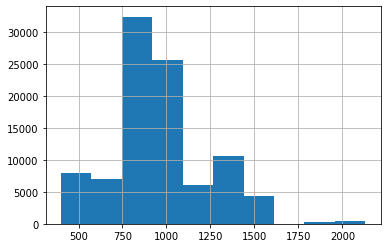

In [284]:
df['price'].hist()

Seems to be relatively well distributed with a mean of around 850. Slightly positively skewed (as there are rooms which cost upwards of 2000)

<AxesSubplot:>

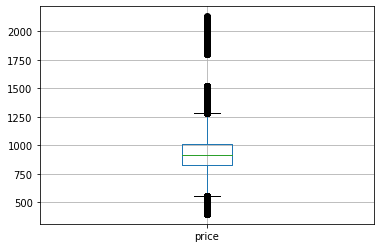

In [285]:
df.boxplot(column = 'price')

There seems to be a large number of datapoints that the boxplot would consider outliers. I suspect this just might be related to the type of room. Lets take a look at boxplots of price by room type. 

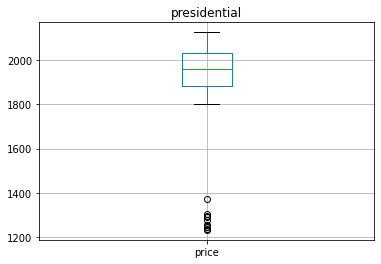

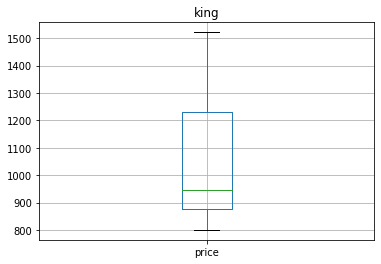

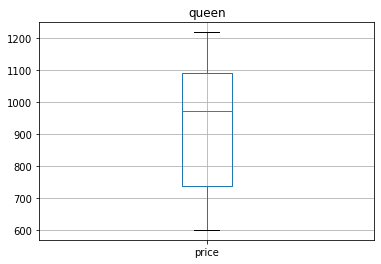

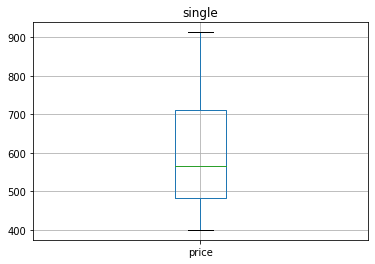

In [299]:
df_king = df[df['room'] == 'King']
df_queen = df[df['room'] == 'Queen']
df_single = df[df['room'] == 'Single']
df_pres = df[df['room'] == 'President Suite']
df_pres.boxplot(column = 'price')
plt.title('presidential')
plt.show()
df_king.boxplot(column = 'price')
plt.title('king')
plt.show()
df_queen.boxplot(column = 'price')
plt.title('queen')
plt.show()
df_single.boxplot(column = 'price')
plt.title('single')
plt.show()

Based on the above boxplots, i think most of the variation in price and the various outliers shown on the price boxplot can be explained by the different room type. This also shows that there is likely to be a high correlation between room type and price which makes sense. However, we also note that within the various room types, there seems to be a large amount of variation within the price of the room.

In [331]:
pd.pivot_table(df, index = ['room', 'booked_months_before'], values = 'price')

price
room            booked_months_before             
King            0                     1062.742386
                1                     1031.876390
                2                     1021.671880
                3                     1025.890115
                4                     1037.136502
                5                     1015.558107
                6                     1024.598802
                7                     1023.378117
                8                     1010.664586
                9                     1022.819930
                10                    1019.479135
                11                    1032.499518
President Suite 0                     1926.513824
                1                     1949.111702
                2                     1955.966538
                3                     1955.165758
                4                     1967.258611
                5                     1964.392857
                6                     1938.019464
                7                     1930.045909
                8                     1960.215366
                9                     1964.893273
                10                    1964.437949
                11                    1931.216667
Queen           0                      941.260960
                1                      926.077902
                2                      919.291754
                3                      912.827798
                4                      921.620193
                5                      925.812886
                6                      911.323184
                7                      939.259596
                8                      922.939984
                9                      930.212316
                10                     917.452164
                11                     935.179178
Single          0                      610.342938
                1                      616.017498
                2                      593.029732
                3                      606.856485
                4                      594.311831
                5                      587.869321
                6                      587.959607
                7                      600.231790
                8                      606.680103
                9                      596.107995
                10                     604.514089
                11                     601.397340

Looking at the average price for each room in all the months, there does not seem to be any obvious relationship between the months and the room price. We will now take a look at the booked_months_before feature.

##### booked_months_before

<AxesSubplot:>

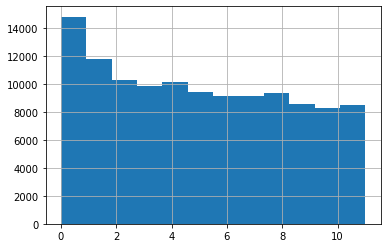

In [65]:
df['booked_months_before'].hist(bins = 12) #1 for each month 0-11

It seems that the majority of the bookings were made 0 months before the booking (within the same month). With the 2nd most bookings being made 1 month before the arrival date. Lets take a look at a boxplot of this feature. I will now take a look at the number of months booked before against country of traveller. I suspect that the Singapore travellers would be mostly booking close to the date because it would mostly be staycations which tend not to be planned too far in advance. Will be investigating this in a later section.

<AxesSubplot:>

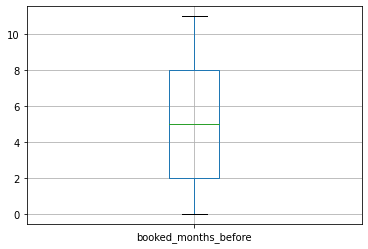

In [315]:
df.boxplot(column = 'booked_months_before')

This is not very useful because this feature's values only range between 0 - 12. Might be better to treat it as categorical. 

In [313]:
pd.pivot_table(df, index = 'country', values = 'booked_months_before')

,booked_months_before
country,
Australia,5.398714
China,4.802243
India,5.082394
Indonesia,5.023981
Japan,5.194761
Malaysia,5.317047
Singapore,5.008947


Observations: 


In [244]:
numerical_features = ['days_booked', 'price', 'booked_months_before', 'arrival_day', 'checkout_day']
df[numerical_features].corr()

,days_booked,price,booked_months_before,arrival_day,checkout_day
days_booked,1.000000,0.029703,0.038389,-0.033090,0.002446
price,0.029703,1.000000,-0.035265,-0.006110,-0.005829
booked_months_before,0.038389,-0.035265,1.000000,-0.012627,-0.019743
arrival_day,-0.033090,-0.006110,-0.012627,1.000000,0.626760
checkout_day,0.002446,-0.005829,-0.019743,0.626760,1.000000


We have a lot of information presented to us here. There are a few key correlations i want to highlight which are very interesting:  
&emsp; 1. There is a slight positive correlation between **days_booked** and **price**. As this is only slight, this leads to me concluding that